## Анализ результатов АБ-теста по влиянию изменений на web-странице на действия пользователей в браузере. 

### Описание данных

В нашем распоряжении имеются данные после АБ-теста, проведенного на реальных пользователях Яндекса. 
Данные содержат информацию по кликам пользователей на «контрольной» и «экспериментальной» версиях web-страницы.

Есть информация о том, с какого браузера заходил пользователь, какое количество запросов он совершил, какое количество кликов он совершил в данных запросах, а также информация о покупках пользователя.

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользователь совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Особенность данных: не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная используемая метрика: количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

### Постановка задачи

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса;
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами;
- определить характер этих изменений и практическую значимость вводимого изменения;
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение).

#### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### 1. Анализ данных АБ-теста

In [2]:
browser_data = pd.read_csv('ab_browser_test.csv')
browser_data.head()
browser_data.info()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


Видим, что в данных нет пропущенных значений.

Изменим текстовые значения в столбце `browser` на целочисленные для удобства.

In [3]:
browser_data['browser'] = browser_data['browser'].apply(lambda x: int(x.split('#')[1]))
browser_data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,2,exp,23,32,19
1,3,4,exp,3,4,2
2,5,4,exp,29,35,16
3,6,4,control,12,6,0
4,7,4,exp,54,68,30


##### Посмотрим разбиение пользователей по группам (экспериментальная, тестовая), а также по группе и версии браузера.

In [4]:
browser_data.groupby('slot')[['userID']].count()
browser_data.groupby(['slot', 'browser'])[['userID']].count()

,userID
slot,
control,284554
exp,281580


userID
slot    browser        
control 2         55793
        4         78681
        14        44903
        17        16354
        20        16998
        22        71825
exp     2         54944
        4         78152
        14        44220
        17        16253
        20        16931
        22        71080

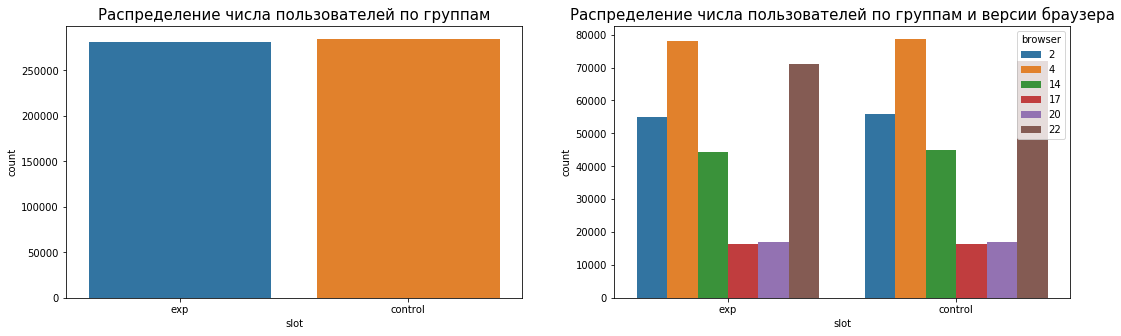

In [5]:
fig, axes = plt.subplots(1,2, figsize=(18,5))
axes[0].set_title("Распределение числа пользователей по группам", fontsize = 15)
axes[1].set_title("Распределение числа пользователей по группам и версии браузера", fontsize = 15)
sns.countplot(x='slot', data=browser_data, ax=axes[0])
sns.countplot(x='slot', hue='browser', data=browser_data, ax=axes[1]);

Видим, что пользователи распределены практически равномерно в разрезе по группам, в тот числе и в разрезе по группе и версии браузера.

В разрезе версий браузера посмотрим в каждой из двух групп (контрольная и экспериментальная) посчитаем долю запросов, в которых пользователь не кликнул ни разу.

In [6]:
browser_data.groupby(['browser','slot'])['n_nonclk_queries'].sum()/browser_data.groupby(['browser','slot'])['n_queries'].sum()

browser  slot   
2        control    0.459627
         exp        0.449827
4        control    0.469709
         exp        0.451429
14       control    0.575904
         exp        0.437556
17       control    0.362994
         exp        0.369374
20       control    0.405405
         exp        0.389774
22       control    0.405940
         exp        0.398539
dtype: float64

Видим большое различие по доле некликов на запросы по группам в браузере с версией 14. В дальнейшем проверим, является ли это отличие статистически значимым.

##### Посмотрим различия по пользовательским кликам в экспериментальной и контрольной группе.

In [7]:
browser_data.groupby('slot')['n_clicks'].sum()

slot
control    3210027
exp        3261823
Name: n_clicks, dtype: int64

Абсолютная разница и разница в процентном соотношении

In [8]:
abs(browser_data.groupby('slot')['n_clicks'].sum()['exp']-browser_data.groupby('slot')['n_clicks'].sum()['control'])
print('Различие в процентах: %.3f' % ((browser_data.groupby('slot')['n_clicks'].sum()['exp']/browser_data.groupby('slot')['n_clicks'].sum()['control']-1)*100))

51796

Различие в процентах: 1.614


Количество кликов в экспериментальной группе увеличлиось более чем на 1.5%.

##### Построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. 

Средние значения кликов по каждой из групп.

In [9]:
browser_data.groupby('slot')['n_clicks'].agg(np.mean)

slot
control    11.280906
exp        11.584001
Name: n_clicks, dtype: float64

Определим функции для бутстрепа и для определения границ доверительного интервала.

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
def build_confidence_interval(experim_group_metric, control_group_metric, mean_parametr):
    np.random.seed(0)
    experim_scores = list(map(mean_parametr,get_bootstrap_samples(experim_group_metric, 500)))
    control_scores = list(map(mean_parametr,get_bootstrap_samples(control_group_metric, 500)))
    experim_interval = stat_intervals(experim_scores, 0.05)
    control_interval = stat_intervals(control_scores, 0.05)
    print(f"95% доверительный интервал для {mean_parametr.__name__} числа кликов в экспериментальной группе: {experim_interval}", 
          f"95% доверительный интервал для {mean_parametr.__name__} числа кликов в контрольной группе: {control_interval}", sep='\n')
    return experim_interval, control_interval

In [13]:
experim_user_clicks = browser_data[browser_data.slot == 'exp'].n_clicks.values
control_user_clicks = browser_data[browser_data.slot == 'control'].n_clicks.values

Построим доверительный интервал для медианных значений количества кликов в каждой из 2 групп.

In [14]:
experim_interval_median, control_interval_median = build_confidence_interval(experim_user_clicks, control_user_clicks, np.median)

95% доверительный интервал для median числа кликов в экспериментальной группе: [5. 5.]
95% доверительный интервал для median числа кликов в контрольной группе: [4. 4.]


Построим доверительный интервал для средних значений количества кликов в каждой из 2 групп.

In [15]:
experim_interval_mean, control_interval_mean = build_confidence_interval(experim_user_clicks, control_user_clicks, np.mean)

95% доверительный интервал для mean числа кликов в экспериментальной группе: [11.50789349 11.6588664 ]
95% доверительный интервал для mean числа кликов в контрольной группе: [11.20668696 11.35347509]


Построим доверительный интервал для разности средних и медианных значений количества кликов между группами.

In [16]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(experim_interval_median, control_interval_median)))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(experim_interval_mean, control_interval_mean)))
print(f"95% доверительный интервал для разности медиан: {delta_median_scores}", 
      f"95% доверительный интервал для разности средних: {delta_mean_scores}", sep='\n')

95% доверительный интервал для разности медиан: [-1.0, -1.0]
95% доверительный интервал для разности средних: [-0.3012065381288913, -0.3053913094314886]


95% доверительные интервалы для разности средних и разности медиан не содержат нуля, что говорит нам о том, что средние и медианы количества кликов в группах имеют статистически значимые различия.

Дополнительно проверим гипотезу о равенстве среднего количества кликов в группах.

### 2. Проверка гипотезы о равенстве среднего количества кликов в экспериментальной и тестовой групппах.

Поcтроим распределение кликов в контрольной и экспериментальной группах.

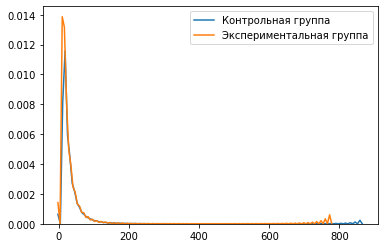

In [17]:
sns.kdeplot(browser_data.loc[browser_data.slot=="control","n_clicks"],label="Контрольная группа")
sns.kdeplot(browser_data.loc[browser_data.slot=="exp","n_clicks"],label="Экспериментальная группа");

Из графика видно, что распределение кликов не похоже на нормальное и у распределения тяжелый правый хвост. Скорее всего данные описываются распределением Пуассона.

##### Сформулируем проверяемую гипотезу:
* H0: среднее количество кликов в группах не отличается
* H1: среднее количество кликов в группах имеет различие

##### Bootstrap и T-критерий Стьюдента

Проверку гипотезы будем осуществлять с использованием  параметрического t-критерия Стьюдента. Но для его использования необходимо, чтобы выполнялись следующие условия:
* среднее значение в выборке было распределено нормально N(μ,σ2n)
* несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)


Оба этих предположения можно проверить с помощью бутстрепа.
Поскольку мы не знаем истинного распределения генеральной совокупности, применим бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.

Для проверки требований t-критерия Стьюдента мы будем использовать контрольную группу, так как распределения в этих двух группах довольно схожи. Мы получим распределение оценок выборочного среднего и выборочной дисперсии и посмотрим, распределены ли они в соответствии с требованиями t-критерия Стьюдента (в силу Центральной предельной теоремы распределение выборочных средних должно быть нормально).

Для этого осуществим следующие действия:

* получим из данных 500 псевдовыборок.
* по каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего
* для получившегося вектора средних значений и сумм квадратов отклонения от выборочного среднего построим q-q plot с помощью scipy.stats.probplot.
* дополнительно проверим нормальность с использованием критерия Шапиро-Уилка.

In [18]:
control_mean_scores = list(map(np.mean,get_bootstrap_samples(control_user_clicks, 500)))
experim_mean_scores = list(map(np.mean,get_bootstrap_samples(experim_user_clicks, 500)))
control_variance_scores = list(map(np.var,get_bootstrap_samples(control_user_clicks, 500)))
experim_variance_scores = list(map(np.var,get_bootstrap_samples(experim_user_clicks, 500)))

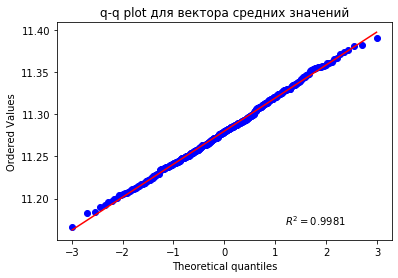

In [19]:
stats.probplot(control_mean_scores,plot = plt, rvalue=True)
plt.title('q-q plot для вектора средних значений');

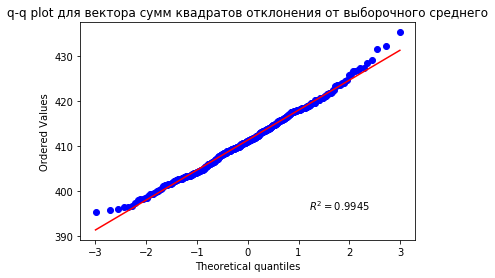

In [20]:
stats.probplot(control_variance_scores,plot = plt, rvalue=True)
plt.title('q-q plot для вектора сумм квадратов отклонения от выборочного среднего');

Дополнительно проверим, что распределение выборочных средних является нормальным с помощью критерия проверки нормальности Шапиро-Уилка.

In [21]:
stats.shapiro(control_mean_scores)[1]<0.05

False

Гипотеза о нормальности распределения не овтергается.

##### Результаты оценки требований T-критерия Стьюдента.
В принципе основываясь на визуальном анализе qq-графика, так и на полученном значении R^2 можно сделать вывод, что больших отклонений от нормальности не наблюдается и требования t-критерия удовлетворены.

Дополнительно этот факт был подтвержден с использованием критерия проверки нормальности Шапиро-Уилка.

##### Применение T-критерия Стьюдента

In [22]:
stats.ttest_ind(control_mean_scores, experim_mean_scores, equal_var=False)

Ttest_indResult(statistic=-122.8198320943985, pvalue=0.0)

T-критерий Стьюдента показал нам статически значимую разницу по среднему количеству кликов в группах. Таким образом нулевая гипотеза отвергается и принимается гипотеза о том, что среднее количество кликов в группах имеет различие.

##### Непараметрический критерий Манна-Уитни

В случае, если требования T-критерия не будут удовлетворены, а количество данных для использования бутстрепа слишком велико, то можно воспользоваться критерием Манна-Уитни. 

Критерий Манна-Уитни представляет непараметрическую альтернативу T-критерия для независимых выборок. Преимущество его состоит в том, что мы отказываемся от предположения нормальности распределения и одинаковых дисперсий. Необходимо, чтобы данные были измерены как минимум в порядковой шкале.

In [23]:
stats.mannwhitneyu(control_mean_scores, experim_mean_scores, alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=5.85617700980204e-165)

Критерий Манна-Уитни также опровергнул нулевую гипотезу о равенстве среднего количества кликов в группах.

На этом проверка гипотез не закончена. Нам также необходимо проверить имеются ли различия в кликах в разрезе используемых браузеров.

### 3. Проверка для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между контрольной и экспериментальной группами, а затем сделаем поправку Холма-Бонферрони на множественную проверку с α=0.05.

In [24]:
mw_p_val_list = []
for browser in browser_data.browser.unique():
    experim_nclicks_on_browser = browser_data[(browser_data.browser == browser) & (browser_data.slot == 'exp')].n_clicks
    control_nclicks_on_browser = browser_data[(browser_data.browser == browser) & (browser_data.slot == 'control')].n_clicks
    mw_p_val_list.append(stats.mannwhitneyu(experim_nclicks_on_browser,control_nclicks_on_browser,alternative="two-sided")[1])
    print("P-value в тесте Манна-Уитни для браузера %s без поправки равно %.4f##" % 
        (browser,
         stats.mannwhitneyu(experim_nclicks_on_browser,control_nclicks_on_browser,alternative="two-sided")[1]))

P-value в тесте Манна-Уитни для браузера 2 без поправки равно 0.0545##
P-value в тесте Манна-Уитни для браузера 4 без поправки равно 0.8152##
P-value в тесте Манна-Уитни для браузера 14 без поправки равно 0.0000##
P-value в тесте Манна-Уитни для браузера 17 без поправки равно 0.0748##
P-value в тесте Манна-Уитни для браузера 20 без поправки равно 0.9073##
P-value в тесте Манна-Уитни для браузера 22 без поправки равно 0.5148##


In [25]:
_, mw_p_val_list_corr, _, _ = multipletests(mw_p_val_list, alpha = 0.05, method = 'holm')
for i, browser in enumerate(browser_data.browser.unique()):
        print("P-value в тесте Манна-Уитни для браузера %s c поправкой Холма-Бонферрони равно %.4f##" % 
        (browser, mw_p_val_list_corr[i]))

P-value в тесте Манна-Уитни для браузера 2 c поправкой Холма-Бонферрони равно 0.2724##
P-value в тесте Манна-Уитни для браузера 4 c поправкой Холма-Бонферрони равно 1.0000##
P-value в тесте Манна-Уитни для браузера 14 c поправкой Холма-Бонферрони равно 0.0000##
P-value в тесте Манна-Уитни для браузера 17 c поправкой Холма-Бонферрони равно 0.2992##
P-value в тесте Манна-Уитни для браузера 20 c поправкой Холма-Бонферрони равно 1.0000##
P-value в тесте Манна-Уитни для браузера 22 c поправкой Холма-Бонферрони равно 1.0000##


Видны значимые изменения в среднем количестве кликов в версии браузера 14.

### 4. Выводы

По результатам тестирования видим значимое изменение в среднем количестве кликов только для браузера 14. Таким образом можно порекомендовать чтобы изменение на web-странице в этом браузере было реализовано для пользователей.

В случае, если бы мы не использовали анализ количества кликов по браузерам, то могли внедрить изменения на все версии браузера, что в дальнейшем могло повлечь негативные изменения в плане опыта пользователей. Например для пользователей с версиями браузера 4, 20 и 22.

Но если мы все таки хотим внедрять изменения для всех браузеров, рекомендуется собрать больше образцов, чтобы убедиться, что для пользователей определенной версии браузера мы не собираемся ухудшать работу.